In [1]:
# Import necessary libraries and modules for your deep learning project

import os  # For file and directory operations
import torch  # PyTorch, the deep learning framework
import torch.nn as nn  # PyTorch's neural network module
import torch.optim as optim  # PyTorch's optimization algorithms
import torch.nn.functional as F  # PyTorch's functional API for neural networks
from torch.utils.data import DataLoader, Dataset  # For working with datasets and data loaders
from torchvision import models, transforms  # PyTorch's vision library for models and data transformations
from PIL import Image  # Python Imaging Library for image operations
from torch.optim.lr_scheduler import StepLR, ExponentialLR  # For learning rate scheduling
import random  # For generating random numbers and operations
import shutil  # For high-level file operations
import numpy as np  # For numerical operations
import tarfile  # For working with tar archives
from torchvision.datasets.utils import download_url  # For downloading data from URLs
import torchvision  # Additional functionality and models for computer vision
import matplotlib.pyplot as plt  # For data visualization

## Question 1

In [2]:
# Dowload the dataset
dataset_url = "https://vis-www.cs.umass.edu/lfw/lfw.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./lfw.tgz', 'r:gz') as tar:
    tar.extractall(path='.')

100%|██████████| 180566744/180566744 [00:04<00:00, 36792043.50it/s]


## Question 2 & 3

In [3]:
# Directory where the dataset is located
data_dir = './lfw'

# Directory where the training data will be saved
train_dir = './data/train'

# Directory where the testing data will be saved
test_dir = './data/test'

# Split ratio for dividing the data into training and testing sets (80% for training, 20% for testing)
split = 0.8

In [4]:
def split_data(source_directory, training_directory, testing_directory, split_ratio):
    """
    Move data from a source directory to training and testing directories based on a given split ratio.

    Args:
    data_dir (str): The source directory containing data to be split.
    training_directory (str): The directory where training data will be moved.
    testing_directory (str): The directory where testing data will be moved.
    split_ratio (float): The ratio of data to be moved to the training set (0.0 to 1.0).

    Returns:
    None
    """

    os.makedirs(training_directory, exist_ok=True)
    os.makedirs(testing_directory, exist_ok=True)

    # Iterate through the source directory
    for person_name in os.listdir(source_directory):
        person_folder = os.path.join(source_directory, person_name)

        # Check if the item in the source directory is a directory and contains more than one item
        if os.path.isdir(person_folder) and len(os.listdir(person_folder)) > 1:
            # Randomly decide whether to move to the training set or testing set
            if random.random() < split_ratio:
                # Move to the training set
                destination_folder = os.path.join(training_directory, person_name)
            else:
                # Move to the testing set
                destination_folder = os.path.join(testing_directory, person_name)

            # Move the entire folder to the appropriate destination
            shutil.move(person_folder, destination_folder)


In [5]:
# Split data by person into train and test sets
split_data(data_dir, train_dir, test_dir, split)

## Question 4

In [6]:
# Create a ResNet-34 model with pretrained weights
model = models.resnet34(pretrained=True)

# Freeze all the model's parameters so they won't be updated during training
for params in model.parameters():
    params.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 102MB/s]


## Question 5 & 6

In [7]:
class SiameseDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        """
        Initialize a Siamese dataset.

        Args:
            image_folder (str): The path to the image folder containing subdirectories for different classes.
            transform (callable, optional): A function/transform to apply to the images.

        Attributes:
            image_folder (str): The path to the image folder.
            transform (callable, optional): A function to transform the images.
            image_list (list): A list of image file paths.

        """
        self.image_folder = image_folder
        self.transform = transform
        self.image_list = []

        # Collect image file paths from subdirectories
        for person in os.listdir(image_folder):
            for img in os.listdir(os.path.join(image_folder, person)):
                self.image_list.append(os.path.join(image_folder, person, img))

    def __len__(self):
        """
        Returns the number of image pairs in the dataset.

        Returns:
            int: The number of image pairs.

        """
        return len(self.image_list)

    def __getitem__(self, idx):
        """
        Get a pair of images and their label at a specified index.

        Args:
            idx (int): Index of the image pair to retrieve.

        Returns:
            tuple: A tuple containing two images and a label.

        """
        img1_path = self.image_list[idx]
        img1 = Image.open(img1_path)
        img1_cl = os.path.split(os.path.split(img1_path)[0])[1]

        # Randomly select a second image
        idx2 = np.random.choice(len(self.image_list))
        img2_path = self.image_list[idx2]
        img2 = Image.open(img2_path)
        img2_cl = os.path.split(os.path.split(img2_path)[0])[1]

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        # Determine whether the images belong to the same class (label 1) or different classes (label 0)
        if img1_cl == img2_cl:
            label = 1
        else:
            label = 0

        return img1, img2, torch.from_numpy(np.array(label, dtype=np.float32))

In [8]:
import torch.nn as nn

class SiameseNetwork(nn.Module):
    def __init__(self, base_model, dropout):
        """
        Initialize a Siamese network.

        Args:
            base_model (nn.Module): A base neural network model.
            dropout (float): Dropout probability for regularization.

        """
        super(SiameseNetwork, self).__init__()
        
        # Assign the base model
        self.model = base_model

        # Modify the classification layer for siamese network (output 2 classes)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=dropout)

    def forward_one(self, x):
        """
        Forward pass for a single input.

        Args:
            x (Tensor): A single input tensor.

        Returns:
            Tensor: Output tensor.

        """
        output = self.model(x)
        output = self.dropout(output)
        return output

    def forward(self, input1, input2):
        """
        Forward pass for pairs of inputs.

        Args:
            input1 (Tensor): The first input tensor.
            input2 (Tensor): The second input tensor.

        Returns:
            Tuple: A tuple containing the output tensors for both inputs.

        """
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)

        return output1, output2

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        """
        Initialize a contrastive loss criterion.

        Args:
            margin (float): The margin that determines the threshold for dissimilar pairs.

        """
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """
        Compute the contrastive loss.

        Args:
            output1 (Tensor): Output tensor for the first input.
            output2 (Tensor): Output tensor for the second input.
            label (Tensor): Binary labels indicating whether the inputs are similar (1) or dissimilar (0).

        Returns:
            Tensor: The computed contrastive loss.

        """
        euclidean_distance = F.pairwise_distance(output1, output2)

        # Contrastive loss formula with margin
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [10]:
# Define a sequence of image transformations
transform = transforms.Compose([
    # Resize the image to 224x224 pixels
    transforms.Resize((224, 224)),
    
    # Randomly crop the image to 224x224 pixels (data augmentation)
    transforms.RandomCrop(224),
    
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    
    # Normalize the image with mean and standard deviation values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
# Create a training dataset using the SiameseDataset class
train_dataset = SiameseDataset(image_folder="data/train", transform=transform)

# Create a data loader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [12]:
# Create a Siamese network using the `SiameseNetwork` class with a base model and dropout
siamese_net = SiameseNetwork(base_model=model, dropout=0.1)

# Define a contrastive loss criterion with a margin of 2.0
criterion = ContrastiveLoss(margin=2.0)

# Set up an Adam optimizer to update the Siamese network's parameters with a learning rate of 0.001
optimizer = optim.Adam(siamese_net.parameters(), lr=0.001)

# Set up a learning rate scheduler for the optimizer with a step size of 10 and a gamma value of 0.1
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [13]:
# Determine the computing device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the Siamese network to the selected computing device
siamese_net = siamese_net.to(device)

# Move the contrastive loss criterion to the same computing device
criterion = criterion.to(device)

In [ ]:
num_epochs = 50
losses = []  # Initialize an empty list to store losses

for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize the loss for the current epoch

    for data in train_loader:
        input1, input2, labels = data  # Extract labels from the dataset
        input1, input2, labels = input1.to(device), input2.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        output1, output2 = siamese_net(input1, input2)

        loss = criterion(output1, output2, labels)  # Calculate the loss

        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the model's parameters
        scheduler.step()  # Adjust the learning rate

        epoch_loss += loss.item()  # Add the batch loss to the epoch loss

    average_loss = epoch_loss / len(train_loader)  # Calculate the average loss for the epoch
    losses.append(average_loss)  # Store the epoch's average loss
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {average_loss:.4f}")

Epoch [1/50] - Loss: 0.4246
Epoch [2/50] - Loss: 0.4117
Epoch [3/50] - Loss: 0.4004
Epoch [4/50] - Loss: 0.4134
Epoch [5/50] - Loss: 0.4106
Epoch [6/50] - Loss: 0.4112
Epoch [7/50] - Loss: 0.4138
Epoch [8/50] - Loss: 0.4067
Epoch [9/50] - Loss: 0.4080
Epoch [10/50] - Loss: 0.4071
Epoch [11/50] - Loss: 0.4164
Epoch [12/50] - Loss: 0.4165
Epoch [13/50] - Loss: 0.4165
Epoch [14/50] - Loss: 0.4047
Epoch [15/50] - Loss: 0.4111
Epoch [16/50] - Loss: 0.4112
Epoch [17/50] - Loss: 0.4068
Epoch [18/50] - Loss: 0.4088
Epoch [19/50] - Loss: 0.4168
Epoch [20/50] - Loss: 0.4111
Epoch [21/50] - Loss: 0.4107
Epoch [22/50] - Loss: 0.4107
Epoch [23/50] - Loss: 0.4106
Epoch [24/50] - Loss: 0.4112
Epoch [25/50] - Loss: 0.4099
Epoch [26/50] - Loss: 0.4113
Epoch [27/50] - Loss: 0.4088
Epoch [28/50] - Loss: 0.4132
Epoch [29/50] - Loss: 0.4056
Epoch [30/50] - Loss: 0.4010
Epoch [31/50] - Loss: 0.4128
Epoch [32/50] - Loss: 0.4126
Epoch [33/50] - Loss: 0.4031
Epoch [34/50] - Loss: 0.4069
Epoch [35/50] - Loss: 0

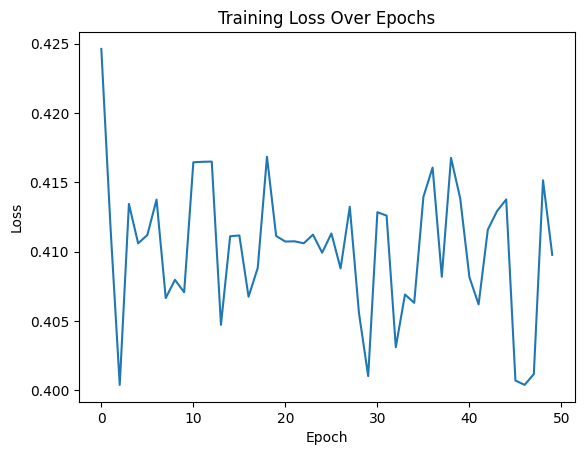

In [ ]:
# Plot the training loss over epochs
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [23]:
def imshow(img, text=None):
    """
    Display an image with optional text.

    Args:
        img (Tensor): The image tensor to display.
        text (str, optional): Text to display on the image.

    """
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

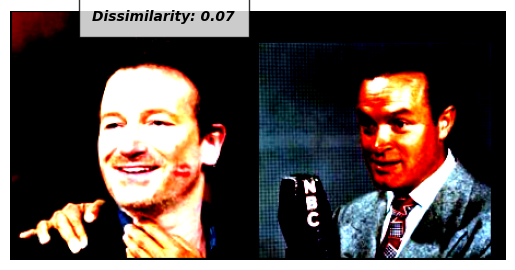

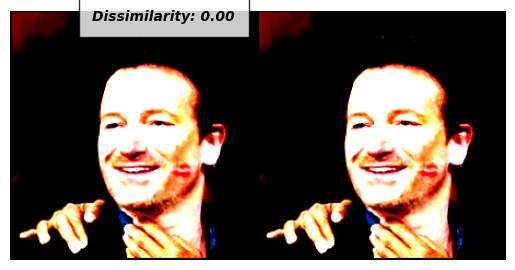

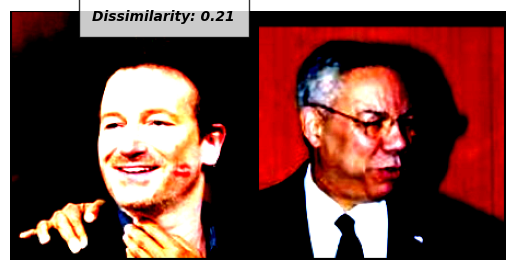

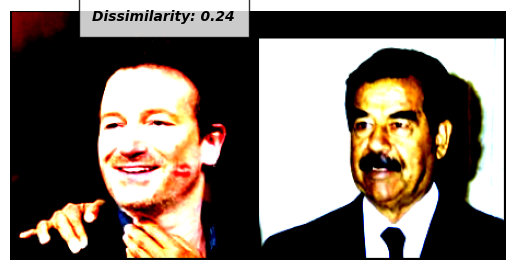

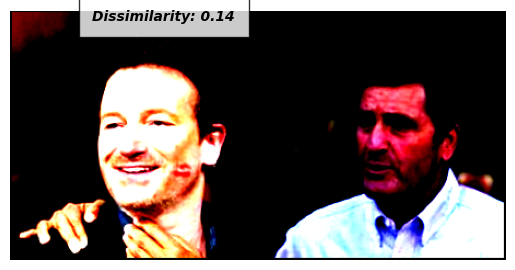

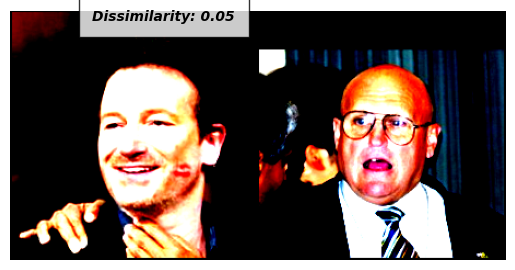

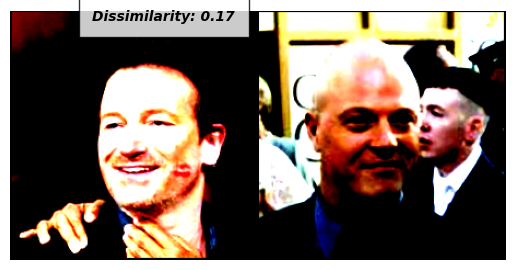

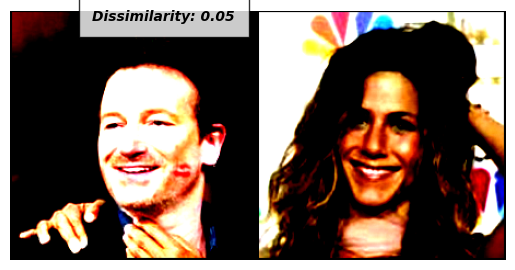

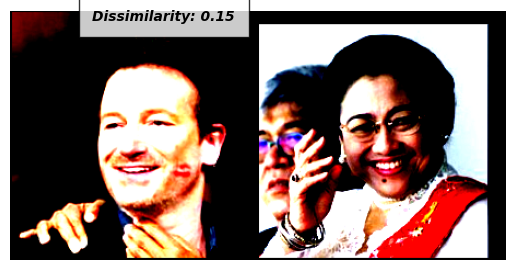

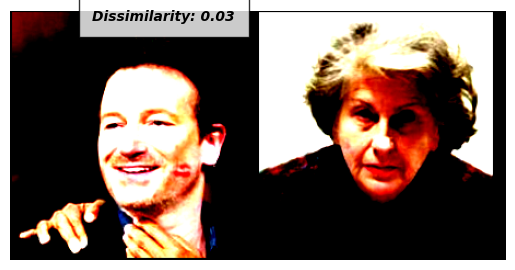

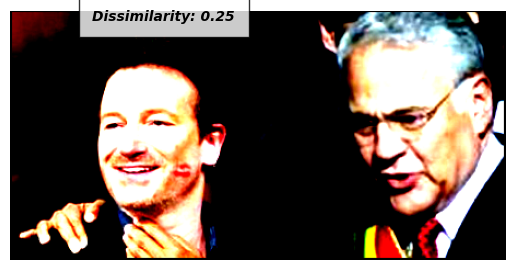

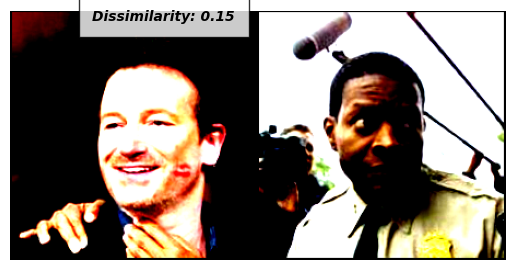

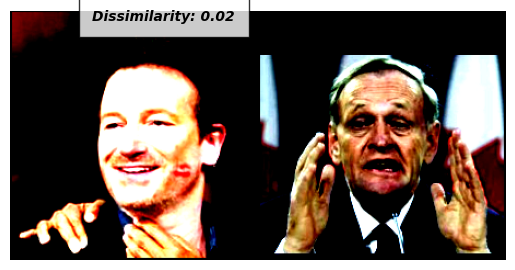

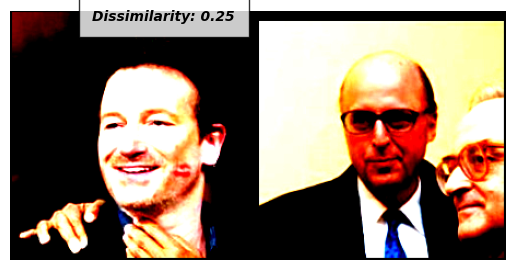

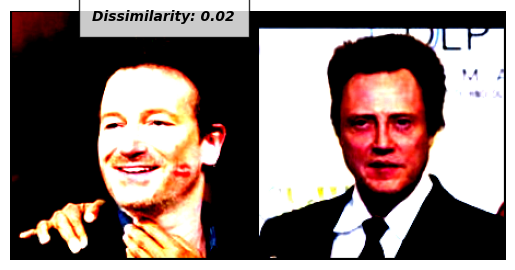

In [ ]:
# Load the test dataset into a SiameseDataset using the provided `test_dir` and transformation
siamese_dataset = SiameseDataset(image_folder=test_dir, transform=transform)

# Create a test data loader with 1 worker, batch size of 1, and shuffling
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab the first image (x0) from the test data
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

# Iterate over 15 images to test them against the first image (x0)
for i in range(15):
    # Get the next image (x1) from the test data
    _, x1, label2 = next(dataiter)

    # Concatenate the two images for visualization
    if i == 1:
        concatenated = torch.cat((x0, x0), 0)
        output1, output2 = siamese_net(x0.cuda(), x0.cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
    else:
        concatenated = torch.cat((x0, x1), 0)
        output1, output2 = siamese_net(x0.cuda(), x1.cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

## Question 8

In [ ]:
# Create a second Siamese network using the `SiameseNetwork` class with a base model and dropout
siamese_net_2 = SiameseNetwork(base_model=model, dropout=0.1)

# Move the second Siamese network to the selected computing device
siamese_net_2 = siamese_net_2.to(device)

# Set up a new optimizer (SGD) for the second Siamese network with a learning rate of 0.001
optimizer_2 = torch.optim.SGD(siamese_net_2.parameters(), lr=0.001)

# Set up a new learning rate scheduler for the second optimizer with a step size of 10 and a gamma value of 0.1
scheduler_2 = StepLR(optimizer_2, step_size=10, gamma=0.1)

In [ ]:
num_epochs = 50
losses = []  # Initialize an empty list to store losses

for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize the loss for the current epoch

    for data in train_loader:
        input1, input2, labels = data  # Extract labels from the dataset
        input1, input2, labels = input1.to(device), input2.to(device), labels.to(device)

        optimizer_2.zero_grad()  # Zero the gradients

        # Forward pass using the second Siamese network
        output1, output2 = siamese_net_2(input1, input2)

        loss = criterion(output1, output2, labels)  # Calculate the loss

        loss.backward()  # Backpropagate the loss
        optimizer_2.step()  # Update the model's parameters
        scheduler_2.step()  # Adjust the learning rate

        epoch_loss += loss.item()  # Add the batch loss to the epoch loss

    average_loss = epoch_loss / len(train_loader)  # Calculate the average loss for the epoch
    losses.append(average_loss)  # Store the epoch's average loss
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {average_loss:.4f}")

Epoch [1/50] - Loss: 0.4113
Epoch [2/50] - Loss: 0.3903
Epoch [3/50] - Loss: 0.3925
Epoch [4/50] - Loss: 0.3957
Epoch [5/50] - Loss: 0.3908
Epoch [6/50] - Loss: 0.3886
Epoch [7/50] - Loss: 0.4020
Epoch [8/50] - Loss: 0.3891
Epoch [9/50] - Loss: 0.3945
Epoch [10/50] - Loss: 0.3862
Epoch [11/50] - Loss: 0.3905
Epoch [12/50] - Loss: 0.3921
Epoch [13/50] - Loss: 0.3974
Epoch [14/50] - Loss: 0.4027
Epoch [15/50] - Loss: 0.3967
Epoch [16/50] - Loss: 0.3960
Epoch [17/50] - Loss: 0.3991
Epoch [18/50] - Loss: 0.3947
Epoch [19/50] - Loss: 0.3966
Epoch [20/50] - Loss: 0.3993
Epoch [21/50] - Loss: 0.4002
Epoch [22/50] - Loss: 0.3866
Epoch [23/50] - Loss: 0.3917
Epoch [24/50] - Loss: 0.3908
Epoch [25/50] - Loss: 0.3969
Epoch [26/50] - Loss: 0.3937
Epoch [27/50] - Loss: 0.3965
Epoch [28/50] - Loss: 0.3962
Epoch [29/50] - Loss: 0.3933
Epoch [30/50] - Loss: 0.3931
Epoch [31/50] - Loss: 0.3925
Epoch [32/50] - Loss: 0.3937
Epoch [33/50] - Loss: 0.3876
Epoch [34/50] - Loss: 0.3894
Epoch [35/50] - Loss: 0

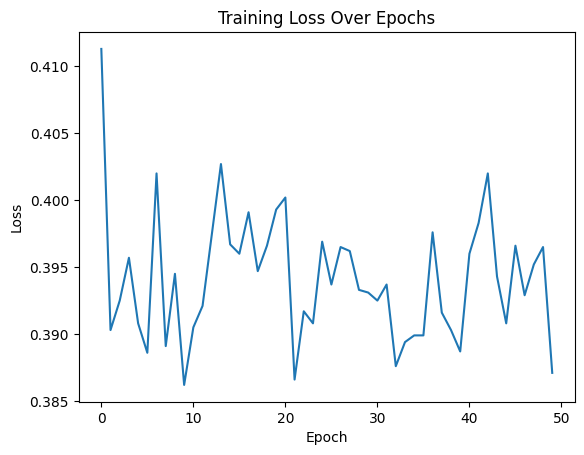

In [16]:
# Plot the training loss over epochs for the second Siamese network
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In comparing the performance of the Adam and SGD optimizers, it is evident that Adam outperforms SGD in terms of both convergence speed and final loss values. The adaptive learning rate and momentum in Adam allow it to dynamically adjust and escape local minima, leading to faster convergence. While SGD can work well with proper tuning, it often requires manual adjustments to the learning rate schedule. Dataset characteristics, problem complexity, and task-specific requirements can influence the choice of optimizer, but in general, Adam's adaptability makes it a popular choice for deep learning tasks.

## Question 7

In [19]:
# Create a third Siamese network using the `SiameseNetwork` class with a base model and dropout
siamese_net_3 = SiameseNetwork(base_model=model, dropout=0.1)

# Move the third Siamese network to the selected computing device
siamese_net_3 = siamese_net_3.to(device)

# Set up a new optimizer (SGD) for the third Siamese network with a learning rate of 0.001
optimizer_3 = torch.optim.SGD(siamese_net_3.parameters(), lr=0.001)

# Set up a new learning rate scheduler for the third optimizer using ExponentialLR with a decay factor (gamma) of 0.95
scheduler_3 = ExponentialLR(optimizer_3, gamma=0.95)

In [20]:
num_epochs = 50
losses = []  # Initialize an empty list to store losses

for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize the loss for the current epoch

    for data in train_loader:
        input1, input2, labels = data  # Extract labels from the dataset
        input1, input2, labels = input1.to(device), input2.to(device), labels.to(device)

        optimizer_3.zero_grad()  # Zero the gradients

        # Forward pass using the third Siamese network
        output1, output2 = siamese_net_3(input1, input2)

        loss = criterion(output1, output2, labels)  # Calculate the loss

        loss.backward()  # Backpropagate the loss
        optimizer_3.step()  # Update the model's parameters
        scheduler_3.step()  # Adjust the learning rate

        epoch_loss += loss.item()  # Add the batch loss to the epoch loss

    average_loss = epoch_loss / len(train_loader)  # Calculate the average loss for the epoch
    losses.append(average_loss)  # Store the epoch's average loss
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {average_loss:.4f}")

Epoch [1/50] - Loss: 0.2712
Epoch [2/50] - Loss: 0.2043
Epoch [3/50] - Loss: 0.2079
Epoch [4/50] - Loss: 0.2037
Epoch [5/50] - Loss: 0.2092
Epoch [6/50] - Loss: 0.2016
Epoch [7/50] - Loss: 0.2051
Epoch [8/50] - Loss: 0.2005
Epoch [9/50] - Loss: 0.2026
Epoch [10/50] - Loss: 0.1983
Epoch [11/50] - Loss: 0.2043
Epoch [12/50] - Loss: 0.2072
Epoch [13/50] - Loss: 0.2001
Epoch [14/50] - Loss: 0.2047
Epoch [15/50] - Loss: 0.2044
Epoch [16/50] - Loss: 0.2020
Epoch [17/50] - Loss: 0.2019
Epoch [18/50] - Loss: 0.2062
Epoch [19/50] - Loss: 0.2063
Epoch [20/50] - Loss: 0.2024
Epoch [21/50] - Loss: 0.2068
Epoch [22/50] - Loss: 0.2083
Epoch [23/50] - Loss: 0.2021
Epoch [24/50] - Loss: 0.2080
Epoch [25/50] - Loss: 0.2054
Epoch [26/50] - Loss: 0.2068
Epoch [27/50] - Loss: 0.2018
Epoch [28/50] - Loss: 0.2023
Epoch [29/50] - Loss: 0.2049
Epoch [30/50] - Loss: 0.2068
Epoch [31/50] - Loss: 0.2018
Epoch [32/50] - Loss: 0.2086
Epoch [33/50] - Loss: 0.2119
Epoch [34/50] - Loss: 0.1978
Epoch [35/50] - Loss: 0

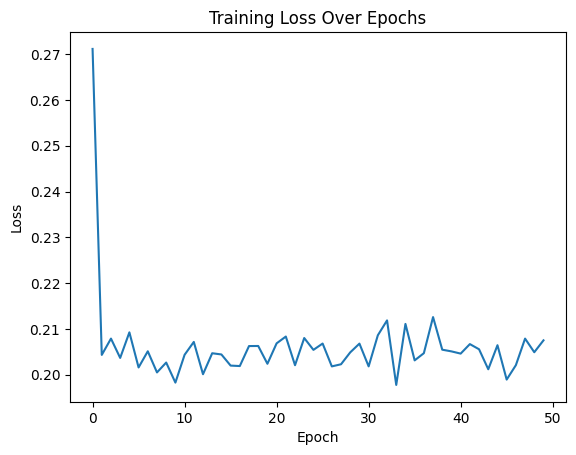

In [21]:
# Plot the training loss over epochs for the third Siamese network
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

The ExponentialLR scheduler effectively reduces the learning rate over epochs, contributing to smoother and consistent training with gradually decreasing loss values. In contrast, the StepLR scheduler exhibits initial instability and higher loss values due to an aggressive initial learning rate. However, it stabilizes later in training, resulting in smoother convergence. The choice between these schedulers depends on the specific problem and dataset, with the potential for improved performance by fine-tuning the hyperparameters of the StepLR scheduler to ensure a more stable initial learning rate. Careful adjustment of the learning rate schedule is crucial for both schedulers to optimize training effectively.

## Question 9

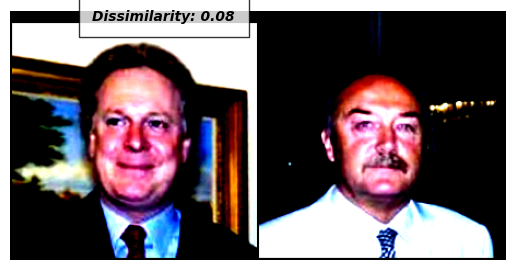

different person


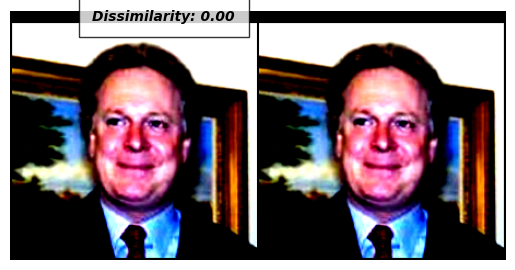

same person


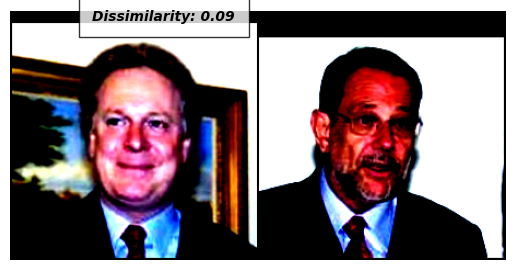

different person


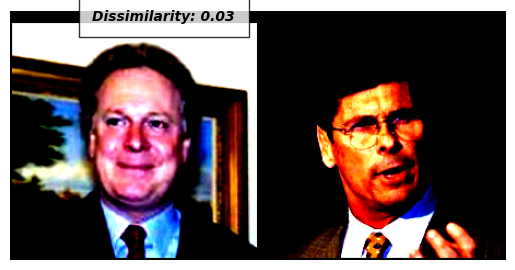

same person


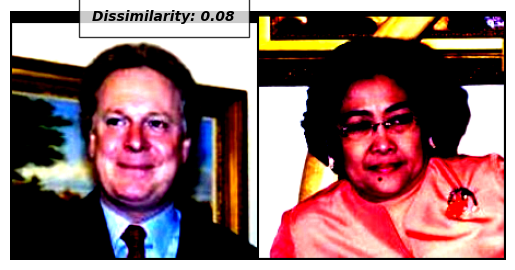

different person


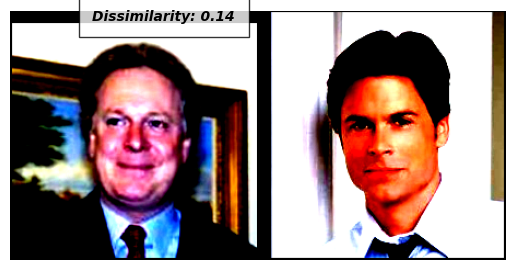

different person


In [40]:
# Load the test dataset into a SiameseDataset using the provided `test_dir` and transformation
siamese_dataset = SiameseDataset(image_folder=test_dir, transform=transform)

# Create a test data loader with 1 worker, batch size of 1, and shuffling
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab the first image (x0) from the test data
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

# Iterate over 6 more images to test them against the first image (x0)
for i in range(6):
    # Get the next image (x1) from the test data
    _, x1, label2 = next(dataiter)

    # Concatenate the two images for visualization
    if i == 1:
        concatenated = torch.cat((x0, x0), 0)
        output1, output2 = siamese_net_3(x0.cuda(), x0.cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
        if euclidean_distance.item() >= 0.05:
            print("different person")
        else:
            print("same person")
    else:
        concatenated = torch.cat((x0, x1), 0)
        output1, output2 = siamese_net_3(x0.cuda(), x1.cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
        if euclidean_distance.item() >= 0.05:
            print("different person")
        else:
            print("same person")

## Question 10

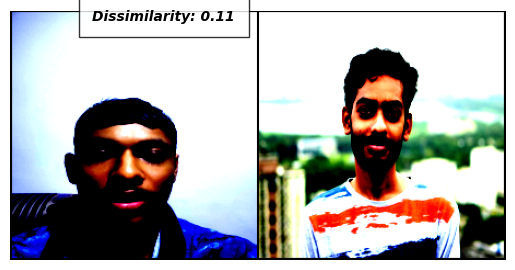

different person


In [42]:
# Load and preprocess your image
your_image = Image.open('/content/images/me/me_3.jpeg')
your_image = transform(your_image)  # Apply the same transform as your training data

# Load and preprocess your friend's image
friend_image = Image.open('/content/images/friend/friend.jpeg')
friend_image = transform(friend_image)

# Move the images to the CUDA-enabled device and reshape
your_image = your_image.unsqueeze(0).cuda()
friend_image = friend_image.unsqueeze(0).cuda()

# Calculate the similarity using the third Siamese network
output1, output2 = siamese_net_3(your_image, friend_image)
euclidean_distance = F.pairwise_distance(output1, output2)

# Concatenate the images for visualization
concatenated = torch.cat((your_image, friend_image), 0)
imshow(torchvision.utils.make_grid(concatenated.cpu()), f'Dissimilarity: {euclidean_distance.item():.2f}')

# Classify the images as "Different person" or "Same person" based on the threshold
if euclidean_distance.item() >= 0.05:
    print("Different person")
else:
    print("Same person")

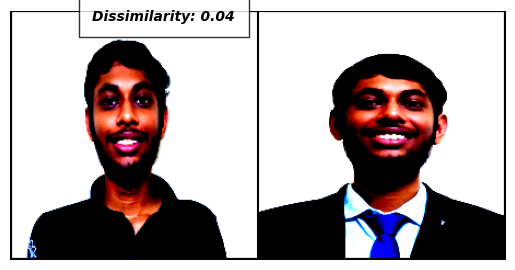

same person


In [41]:
# Load and preprocess your image
your_image = Image.open('/content/images/me/me.jpeg')
your_image = transform(your_image)  # Apply the same transform as your training data

# Load and preprocess another image
friend_image = Image.open('/content/images/me/me_2.jpeg')
friend_image = transform(friend_image)

# Move the images to the CUDA-enabled device and reshape
your_image = your_image.unsqueeze(0).cuda()
friend_image = friend_image.unsqueeze(0).cuda()

# Calculate the similarity using the third Siamese network
output1, output2 = siamese_net_3(your_image, friend_image)
euclidean_distance = F.pairwise_distance(output1, output2)

# Concatenate the images for visualization
concatenated = torch.cat((your_image, friend_image), 0)
imshow(torchvision.utils.make_grid(concatenated.cpu()), f'Dissimilarity: {euclidean_distance.item():.2f}')

# Classify the images as "Different person" or "Same person" based on the threshold
if euclidean_distance.item() >= 0.05:
    print("Different person")
else:
    print("Same person")

**Resources:**
1. [ChatGPT](https://chat.openai.com/)
2. [PyTorch Tutorials](https://pytorch.org/tutorials/)
3. [PyTorch Vision Documentation](https://pytorch.org/vision/stable/index.html)